Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/IIC/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 5.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=deadf5aa0f53421eb1e952b9c7db16698c76b1f1a23cc850dab63480c7db6cc7
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import cv2
from tensorflow import keras
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import seaborn as sns

Loading the Model
---

In [ ]:
model = load_model('models/mnist.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

Classifier Function
---

In [ ]:
def prepare_img(filepath):
    img_name = filepath.split('/')[-1]
    im = np.array(Image.open(filepath).convert('L'))
    im = cv2.resize(im, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    im = gray2rgb(im.reshape(28,28))
    return im

In [ ]:
def classify_img(model, img):
    img = img.reshape((1,img.shape[0],img.shape[1],3))
    img = img.astype("float32") / 255
    pred = model(img)[0]
    class_idx = np.argmax(pred)
    return class_idx

Data Preparation
---

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 3)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 3)
x_train = gray2rgb(x_train.reshape(x_train.shape[0],28,28))
x_test = gray2rgb(x_test.reshape(x_test.shape[0],28,28))

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 3)
60000 train samples
10000 test samples


LIME
---

Making an explainer object

In [ ]:
explainer = lime_image.LimeImageExplainer()

Visualizing LIME results for three random pictures from the testing dataset</br>
According to the [documentation](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_image), the grey parts do not contribute positively to the prediction of the label.  

In [ ]:
def plot_explanation(input_image, model):
    explanation = explainer.explain_instance(input_image, model.predict)
    label = model.predict(input_image.reshape((1,28,28,3))).argmax(axis=1)[0]
    temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
random_dict = {0: [6127, 5526, 8152],
             1: [7911, 9594, 5327],
             2: [9686, 5615, 6234],
             3: [3476, 8570, 6103],
             4: [6205, 2709, 1680],
             5: [2556, 1967, 3552],
             6: [1250, 1212, 3846],
             7: [5040, 328, 5563],
             8: [5129, 6595, 5976],
             9: [7651, 1640, 9562]}

Category: 0



Category: 1



Category: 2



Category: 3



Category: 4



Category: 5



Category: 6



Category: 7



Category: 8



Category: 9


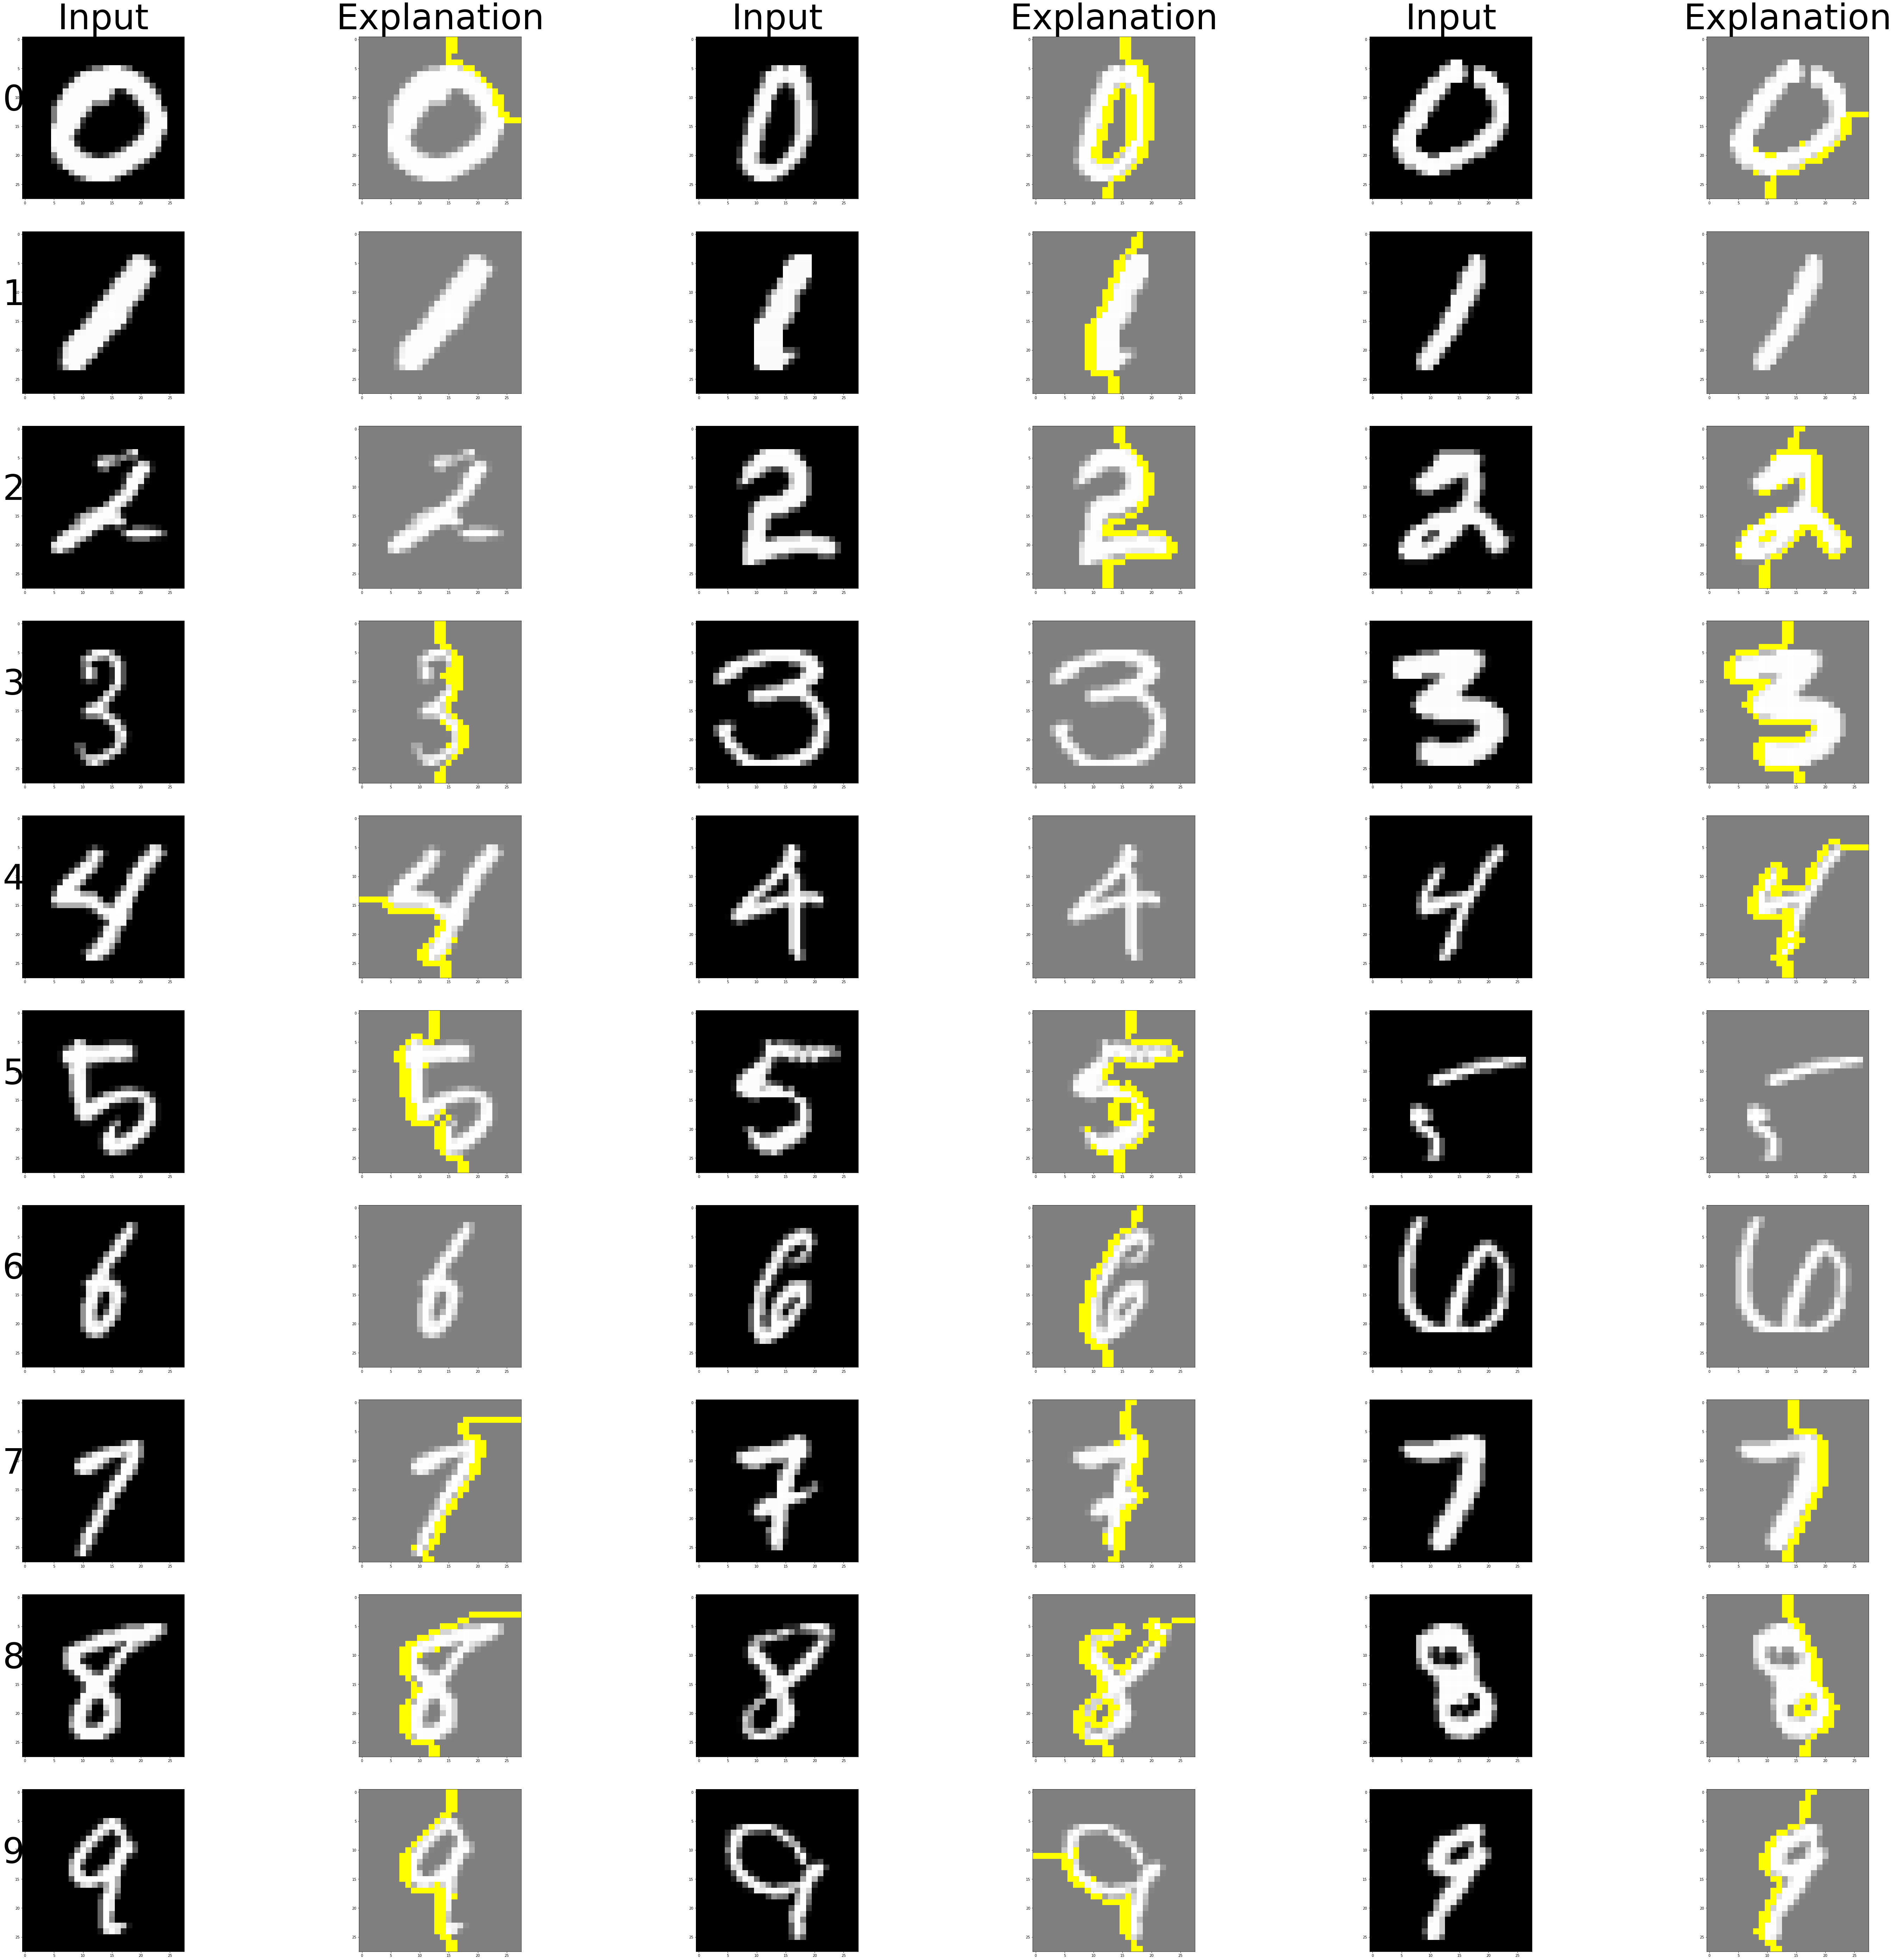

In [ ]:
f, axarr = plt.subplots(10, 6, figsize=(100,100))


cols = ['Input','Explanation','Input','Explanation','Input','Explanation']
rows = [str(i) for i in range(10)]

for ax, col in zip(axarr[0], cols):
    ax.set_title(col, size=100)
for ax, row in zip(axarr[:,0], rows):
    ax.set_ylabel(row, rotation=0, size='large', fontsize = 100.0)

for cat_idx, (key, values) in enumerate(random_dict.items()):
    print('Category: '+str(key))
    for val_idx, value in enumerate(values):
        input_image = x_test[value]
        axarr[cat_idx, val_idx*2].imshow(input_image)
        explanation = explainer.explain_instance(input_image, model.predict)
        label = model.predict(input_image.reshape((1,28,28,3))).argmax(axis=1)[0]
        temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=5, hide_rest=True)
        axarr[cat_idx, 2*val_idx+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))